# Chini Tang HW4 Q2
# Fourier ptychography


Ptychography measures a scene of interest with a local spotlight

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io, transform, filters,exposure
from skimage.transform import rescale
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})
from google.colab import files
import random
import cv2
from joblib import Parallel, delayed
import time

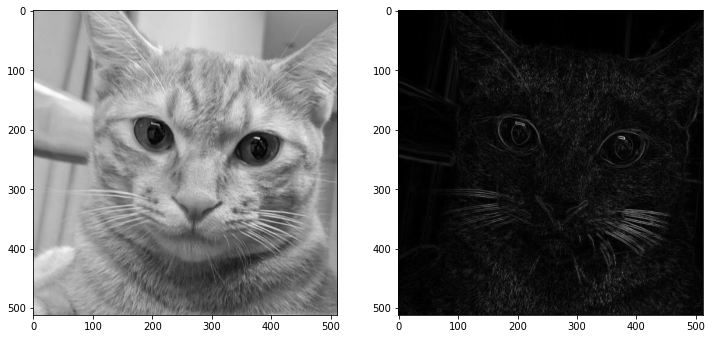

In [ ]:
im = cv2.imread('cat.jpg',0)[350:350+512,200:200+512]/255
im=im-np.mean(im)
plt.figure(figsize= (12,6))
imf=filters.roberts(im)
plt.subplot(1,2,1)
plt.imshow(im,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(imf,cmap = 'gray')

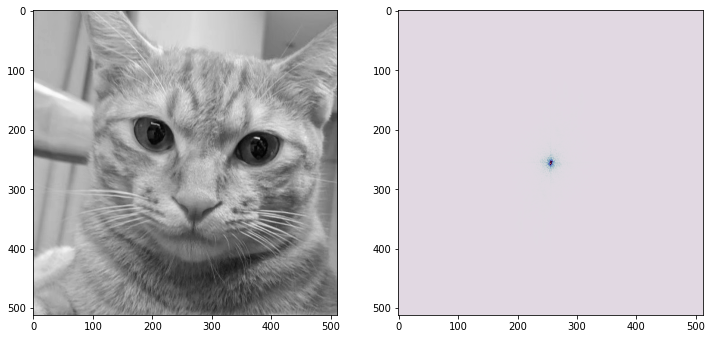

In [ ]:
plt.figure(figsize= (12,6))
imfT = np.fft.fftshift(np.fft.fft2(im))
plt.subplot(1,2,1)
plt.imshow(im,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(imfT),cmap = 'twilight')

In [ ]:
def newfft(arr):
  return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(arr)))

def newifft(arr):
  return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(arr)))
  
def get_pupil(apD):
  r = apD/2
  y,x = np.ogrid[-r+0.5: r:1, -r+0.5: r]
  disk = x**2+y**2 <= r**2 
  disk = disk.astype(float)
  return disk

def pyMeasurement(x,y, im):
  mask=np.zeros(im.shape)
  mask[(x-64):(x+64),(y-64):(y+64)]=get_pupil(128)
  gx=mask*im
  # gu = np.fft.ifft2(np.fft.fftshift(gx))
  gu = newifft(gx)
  return gx, gu


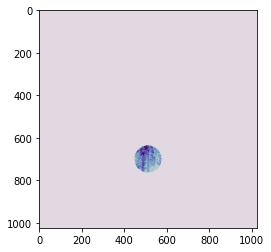

In [ ]:
# plt.imshow(np.abs(b)**2, cmap='twilight')
# plt.imshow(np.abs(a), cmap='twilight')

b_fft = newfft(b)
plt.imshow(np.abs(b_fft), cmap='twilight')

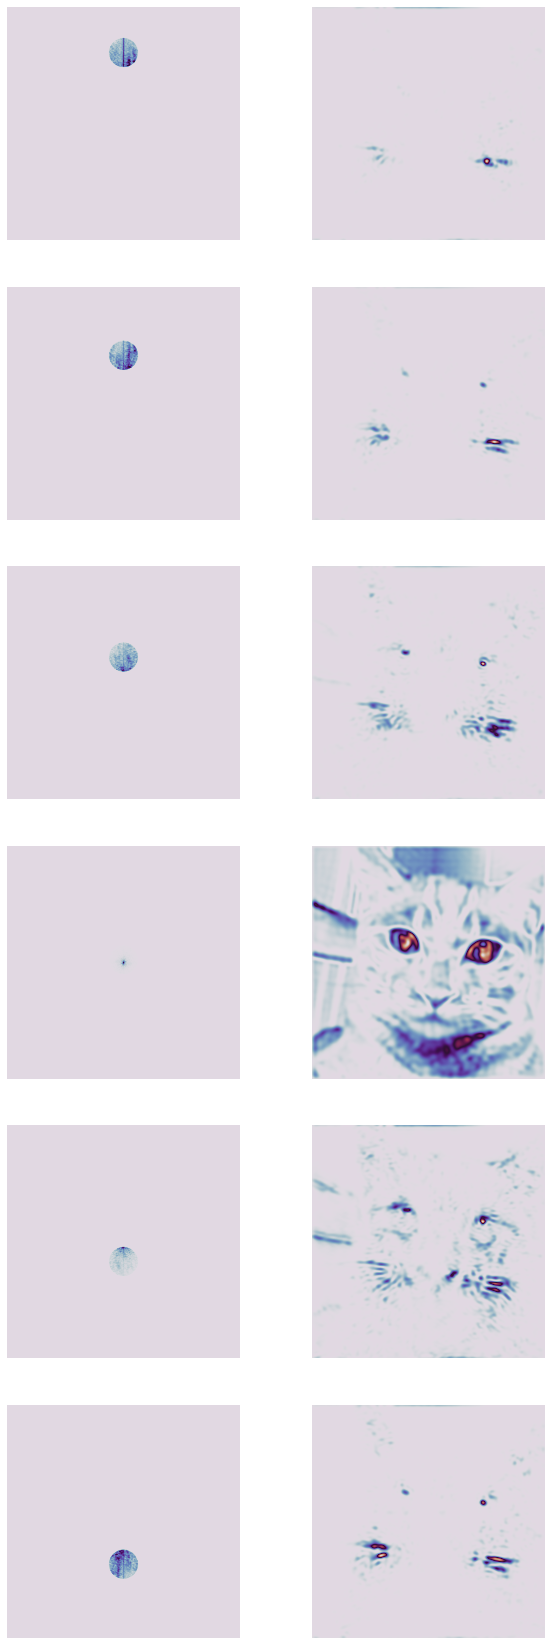

In [ ]:
plt.figure(figsize= (10,30))
imP=np.pad(im,256)
imFT=newfft(imP)
for pip in range(6):
  a,b= pyMeasurement(pip*100+200,512,imFT)
  plt.subplot(6,2,2*pip+1)
  plt.imshow(np.abs(a), cmap='twilight')
  plt.axis('off')
  plt.subplot(6,2,2*pip+2)
  plt.imshow(np.abs(b[256:768,256:768])**2, cmap='twilight')
  plt.axis('off')

In [ ]:
input_dim = 512     # image dimension (512,512)
pad = 8 + 25       # Adding padding to the fourier space
measure_dim = 128     # diameter of the aperture
spacing = int(np.round(128 * (1-0.61)))   # spacing between apertures, ensure 61% overlap

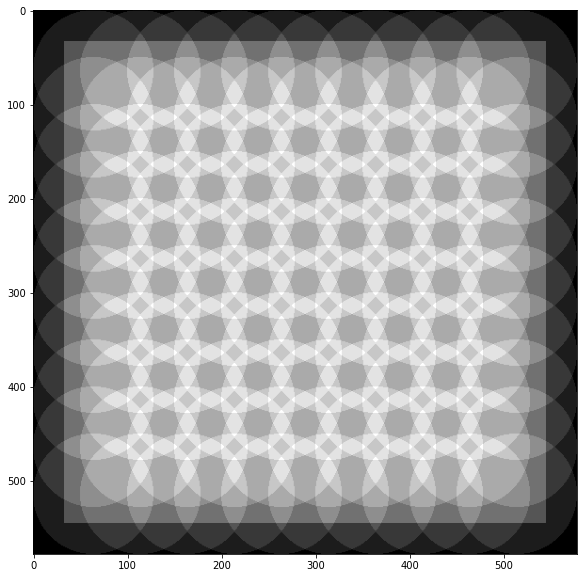

In [ ]:
mesh = np.arange(0,input_dim + 2  * pad - measure_dim + 1,spacing)
xlocations,ylocations = np.meshgrid(mesh,mesh);
xlocations = xlocations.astype(int).flatten()
ylocations = ylocations.astype(int).flatten()
num_frame = len(mesh)**2

dim_measure = np.ones([num_frame],'int') * measure_dim
cam_locations = np.concatenate([xlocations.reshape([-1,1]),ylocations.reshape([-1,1])],1)
  
## pattern
pattern = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
pattern[pad:input_dim + pad,pad:input_dim + pad] = 2
for i in range(len(dim_measure)):
    pattern[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
            cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]] += get_pupil(dim_measure[i])
plt.figure(figsize = (10,10))
plt.imshow(pattern,cmap='gray')
plt.show()

In [ ]:
pattern = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
for i in range(len(dim_measure)):
    pattern[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
            cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]] += get_pupil(dim_measure[i])
pattern = np.maximum(1,pattern) ## ensure not divided by 0

In [ ]:
def get_measurement(im,photons,is_noisy,is_energy_constraint):
    X = np.zeros([num_frame,measure_dim,measure_dim])
    x = np.pad(np.fft.fftshift(np.fft.fft2(im.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    if is_energy_constraint == True:
        x = x / np.sqrt(pattern)
    for i in range(num_frame):
        X[i,:,:] = np.abs(np.fft.ifft2(x[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
                                        cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]]* get_pupil(dim_measure[i]))) *np.sqrt(photons) * dim_measure[i]
    if is_noisy:
        X = np.sqrt(np.random.poisson(np.power(X,2)))
    return X/np.sqrt(photons)

Phase retrieval from the spectrogram data can be implemented using Gerchberg-Saxton
error reduction.

1. Use the current image estimate to estimate the Fourier transform filtered to the current subwindow
2. Replace the magnitude of signal with the measured value, and keep the current estimate of the phase.
3. Inverse Fourier transform and add to the current new estimate of f(x).
3. Proceed to the next subwindow returning to step 1 

In [ ]:
def reconstruction(measure,is_energy_constraint):
    ## AP
    initial_image = cv2.resize(measure[45,:,:],(512,512))
    xest = np.pad(np.fft.fftshift(np.fft.fft2(initial_image.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    order = list(range(num_frame))
    for iter_ in range(100):
        xest[0:pad,:] = 0
        xest[pad+512:pad*2 + 512,:] = 0
        xest[:,0:pad] = 0
        xest[:pad+512:pad*2 + 512] = 0
        random.shuffle(order)
        for im_idx in order:
            im = np.fft.ifft2(xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]]*get_pupil(dim_measure[im_idx]))
            
            im = measure[im_idx,:,:].astype('complex128') * np.exp(1j * np.angle(im)) # retain the phase
            xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
               cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]] = xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
              cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]]*(1-get_pupil(dim_measure[im_idx])) + np.fft.fft2(im) / dim_measure[im_idx] * get_pupil(dim_measure[im_idx])
    
    if is_energy_constraint == True:
        estimate = np.fft.ifft2(np.fft.ifftshift(xest[pad:pad + input_dim,pad:pad + input_dim] * np.sqrt(pattern[pad:pad + input_dim,pad:pad + input_dim]))) * input_dim
    else:
        estimate = np.fft.ifft2(np.fft.ifftshift(xest[pad:pad + input_dim,pad:pad + input_dim])) * input_dim
    return estimate

In [ ]:
def mse_loss(xest,y):
    error = abs(xest)**2 + abs(y)**2-2*np.abs(np.conjugate(xest)*y)
    return np.mean(error)

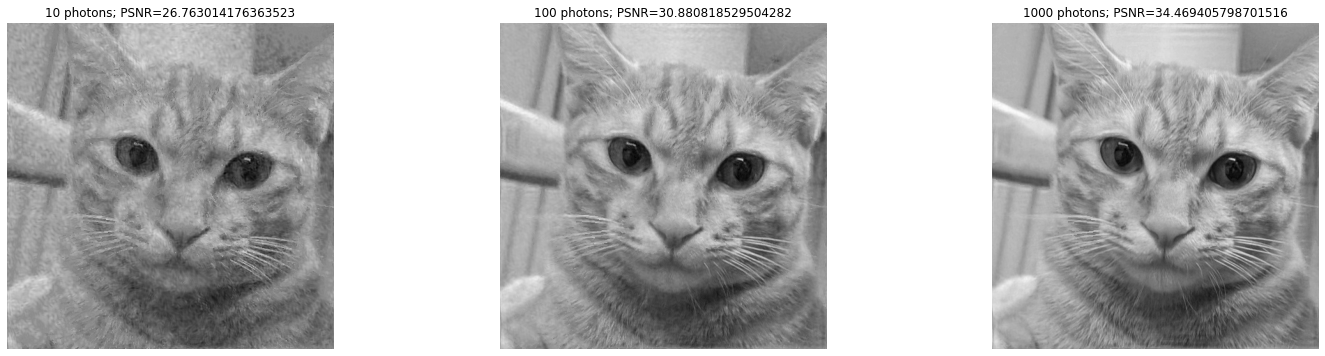

In [ ]:
plt.figure(figsize= (25,6))
for pip in range(3):
  measurement = get_measurement(im,photons = 10**(pip+1),is_noisy = True ,is_energy_constraint = False)
  
  # reconstruction
  estimate = reconstruction(measurement,is_energy_constraint = False)
  rotation=np.conjugate(estimate)*im/(np.abs(estimate)*np.abs(im))
  plt.subplot(1,3,pip+1)
  plt.imshow(np.real(rotation*estimate),cmap='gray')
  plt.title(np.str(10**(pip+1))+' photons; PSNR='+np.str(10*np.log10(1/mse_loss(estimate,im))))
  plt.axis('off')

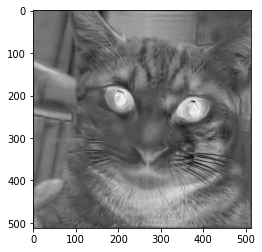

In [ ]:
plt.imshow(np.real(estimate),cmap='gray')

In [ ]:
measurement.shape

(100, 128, 128)

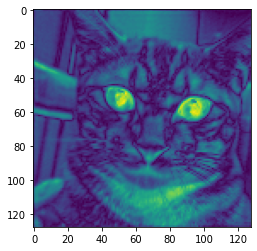

In [ ]:
plt.imshow(measurement[45,:,:])

In [ ]:
measurement.shape

(100, 128, 128)

In [ ]:
estimate.shape

(512, 512)